# Using FACSIMILE to generate a reduced set of tems for predicting factor scores

This notebook provides a quick introduction to using FACSIMILE to generate a reduced set of questionnaire items which can be used to accurately predict factor scores.

We will try to predict the three factors first reported by [Gillan et al., (2016)](https://elifesciences.org/content/5/e11305v1). These factors are:
* Anxious-depression
* Compulsivity and intrusive thought
* Social withdrawal

## Imports

First, import the necessary packages:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from facsimile.eval import FACSIMILEOptimiser
from facsimile.plotting import plot_predictions
from facsimile.utils import (
    check_directories,
    set_style,
    train_validation_test_split,
)

# Make sure we're in the root
check_directories()

# Make things look nice
set_style("style.mplstyle")

# Set matplotlib dpi
plt.rcParams["figure.dpi"] = 100

Changing directory to root directory of repository...
Added new font as Heebo Light
Added new font as Heebo
Added new font as Heebo
Added new font as Heebo Black
Matplotlib style set to: style.mplstyle with font Heebo


## Data

Next, we load the data. Here we're using data from [Hopkins et al. (2022)](https://psyarxiv.com/q83sh/).

In [2]:
items = pd.read_csv("data/items.csv")
factor_scores = pd.read_csv("data/factor_scores.csv")

It is important to split the data into three sets: training, validation, and test. The training set is used to fit the model, the validation set is used to select the best hyperparameter values, and the test set is used to evaluate the optimised model's performance. We can do this using the provided `train_validate_test_split` utility function.

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    items.iloc[:, 2:],  # Drop the first two columns, which are just IDs
    factor_scores.iloc[
        :, 2:
    ],  # Drop the first two columns, which are just IDs
    train_size=0.6,
    test_size=0.2,
    val_size=0.2,
)

## Run the optimiser

The `FACSIMILEOptimiser` class runs an random search across the hyperparameter space to find regalularisation hyperparameter values that provide the best performance on the validation set. 

It is worth running a large number of iterations (e.g., 1000) to ensure that the optimiser has a good chance of finding the best hyperparameter values. However, this can take a long time. To speed things up, we can run the optimiser in parallel across multiple cores. This is done by setting the `n_jobs` parameter to the number of cores to use.

> Note: Here we only run 100 iterations for speed

In [4]:
# Initialise the optimiser
optimiser = FACSIMILEOptimiser(n_iter=100, n_jobs=10)

# Fit
optimiser.fit(
    X_train, y_train, X_val, y_val, target_names=["AD", "Compul", "SW"]
)

Evaluation: 100%|██████████| 100/100 [00:04<00:00, 21.99it/s]


### View the results

The optimiser stores the results of each iteration in a pandas DataFrame. We can view the results using the `results_` attribute.

This contains columns representing the $R^2$ score for each factor on the validation set, the minimum $R^2$ score across all factors, and the hyperparameter values used for each iteration. We also get the number of items retained on each iteration, along with a `score` variable that balances the number of items retained with the minimum $R^2$ score according to the following formula:


$$\text{score} = \min(R^2) \cdot \left(1 - \frac{n_{included}}{n_{total}}\right)$$

Where $n_{included}$ is the number of items included, and $n_{total}$ is the total number of items.


In [5]:
optimiser.results_.head()

,run,r2_AD,r2_Compul,r2_SW,min_r2,max_r2,scores,n_items,alpha_AD,alpha_Compul,alpha_SW
0,0,0.918472,0.944004,0.990711,0.918472,0.990711,0.646007,62,0.648454,0.088522,0.050141
1,1,0.943385,0.797884,0.982315,0.797884,0.982315,0.645179,40,0.281767,0.451665,0.067217
2,2,0.921996,0.754960,0.970634,0.754960,0.970634,0.632144,34,0.422915,0.377139,0.120488
3,3,0.959981,0.944234,0.984295,0.944234,0.984295,0.655091,64,0.263594,0.084933,0.173436
4,4,0.943833,0.838659,0.972880,0.838659,0.972880,0.670125,42,0.267312,0.321228,0.095243


### Plot the results

We can also plot the results using the `plot_results` method. This plots the $R^2$ score for each factor on the validation set, along with the minimum $R^2$ score across all factors, and the number of items included on each iteration.

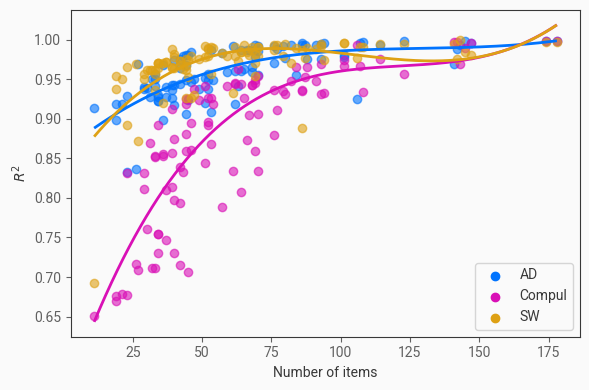

In [6]:
optimiser.plot_results(figsize=(6, 4))

### Get the best classifier

We can get the best classifier from the optimiser using the `get_best_classifier` method. This returns a `FACSIMILEClassifier` object which can be used to predict factor scores for new participants.

The classifier is returned unfitted (i.e., just initialised with the best alpha values), so we then need to call the `fit` method to fit the classifier to the training data.

In [7]:
# Get the best classifier
best_clf = optimiser.get_best_classifier()

# Fit
best_clf.fit(X_train, y_train)

# Print number of items
print("Number of included items: {}".format(best_clf.included_items.sum()))

Best classifier:
Minimum R^2: 0.8921079087880522
Number of included items: 34.0
Number of included items: 34


We can then predict factor scores for the test data using the `predict` method and plot the predicted scores against the true scores.

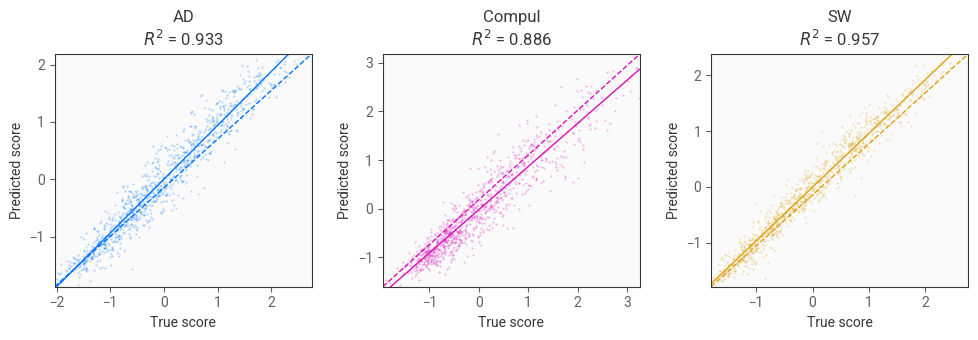

In [8]:
# Get predictions
y_pred = best_clf.predict(X_test)

# Plot
plot_predictions(y_test, y_pred, ["AD", "Compul", "SW"], scale=1)

It is also possible to predict scores using a dataframe containing _only_ the items included by the reduction procedure. This can be done using the `predict_reduced` method.

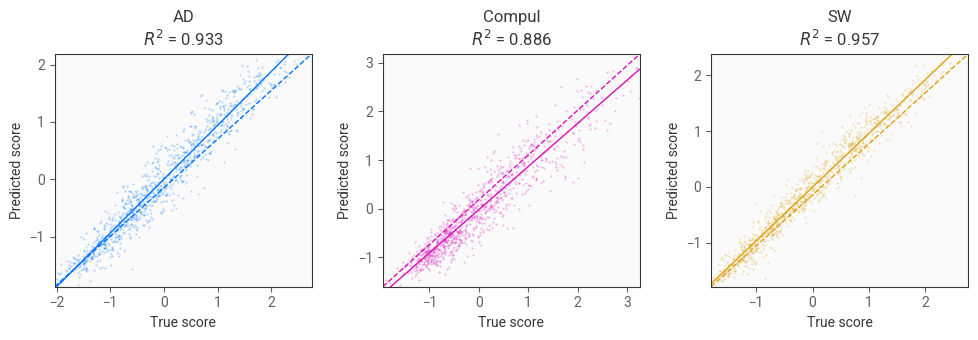

In [9]:
# Select only included items
X_reduced = X_test[
    [i for i in X_test.columns if i in best_clf.included_item_names]
]

# Get predictions
y_pred = best_clf.predict_reduced(X_reduced)

# Plot
plot_predictions(y_test, y_pred, ["AD", "Compul", "SW"], scale=1)

We can also plots the weights for the items included using the `plot_weights()` method.

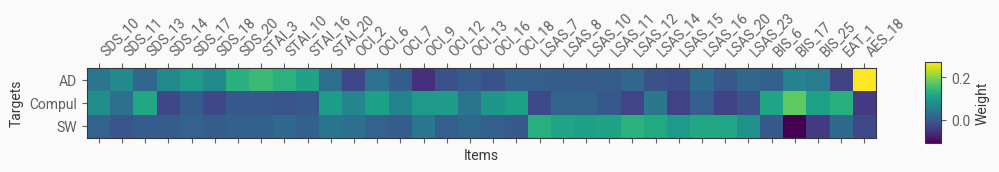

In [10]:
best_clf.plot_weights()

### Get the best classifier for a given number of items

We can also get the best classifier for a given number of items using the `get_best_classifier_max_items` method. This will do the same as above, but only select from classifiers that include up the number of items indicated.

Here we'll get the best classifier that includes up to 70 items.

In [11]:
# Get the best classifier
best_clf_70 = optimiser.get_best_classifier_max_items(70, metric='min_r2')

# Fit
best_clf_70.fit(X_train, y_train)

# Print number of included items
print("Number of included items: {}".format(best_clf_70.included_items.sum()))

Best classifier:
Minimum R^2: 0.9538632961835102
Number of included items: 70.0
Number of included items: 70


Again, we can plot the predicted scores against the true scores.

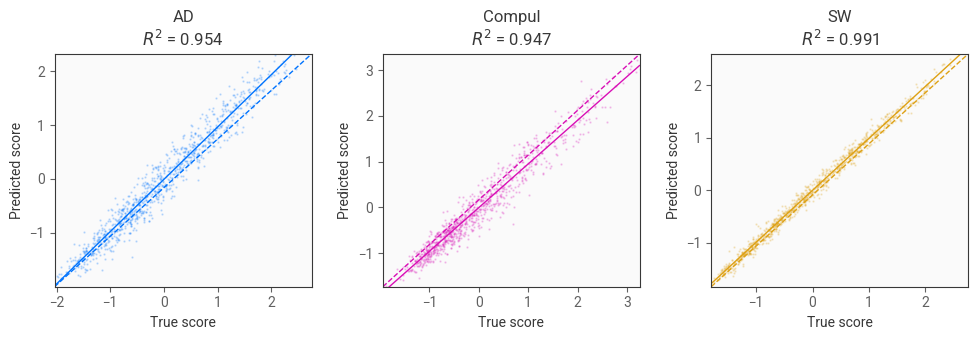

In [12]:
# Get predictions
y_pred_70 = best_clf_70.predict(X_test)

# Plot
plot_predictions(y_test, y_pred_70, ["AD", "Compul", "SW"], scale=1)

And plot the weights

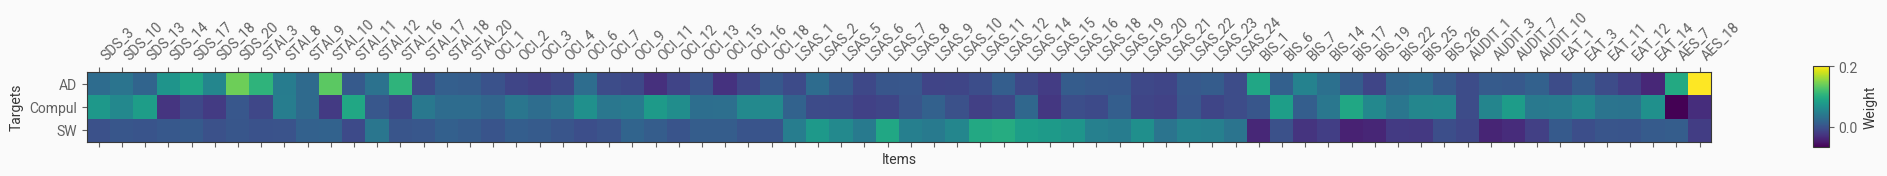

In [13]:
best_clf_70.plot_weights()

### Output the weights

We can also return the weights for each item in the final model as a DataFrame using the `get_weights()` method.

> Note: The model fits an intercept term, which is included in the weights.

In [14]:
best_clf_70.get_weights()

,AD,Compul,SW
SDS_3,0.026517,0.075057,-0.001882
SDS_10,0.035532,0.056962,0.003730
SDS_13,0.018173,0.081756,0.001410
SDS_14,0.071326,-0.027117,0.006045
SDS_17,0.090289,-0.009404,0.007453
...,...,...,...
EAT_12,-0.018566,0.034409,0.001780
EAT_14,-0.038429,0.066682,0.008525
AES_7,0.095090,-0.068055,0.011578
AES_18,0.200290,-0.033137,-0.019205


### Saving and re-using the model

The model can be saved to a file using the `save` method. This saves the model as a pickle file.

In [15]:
best_clf_70.save("data/best_clf_70.pkl")

This can then be loaded in again using the `load_model` function and reused.

In [16]:
from facsimile.utils import load_model

# Load model
best_clf_70_loaded = load_model("data/best_clf_70.pkl")

# Get predictions
y_pred_70 = best_clf_70_loaded.predict(X_test)

It can sometimes be easier to avoid saving and loading the entire model (as this assumes that versions of packages used by the model are the same when saving and loading). Instead, the weights can be exported using the `get_weights()` method (as described above) and then used to predict scores directly, without any need for reloading the model object itself.

We can do this by simply taking the dot product of the weights and the items in the dataframe, and then adding the intercept term.

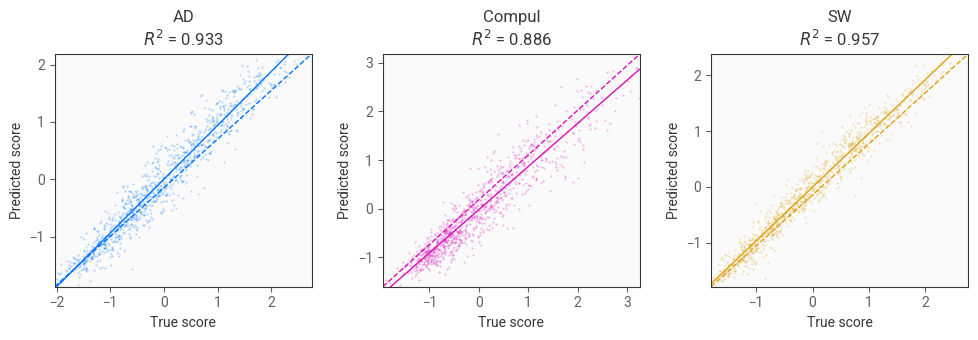

In [17]:
# Get weights dataframe
weights = best_clf.get_weights()

# Get predictions (note that we have to use the values from the dataframe here)
y_pred = X_reduced @ weights.values[:-1] + weights.values[-1]

# Plot predictions
plot_predictions(y_test, y_pred, ["AD", "Compul", "SW"], scale=1)

The `FACSIMILE` package also includes a convenience function for doing this called `simple_predict`

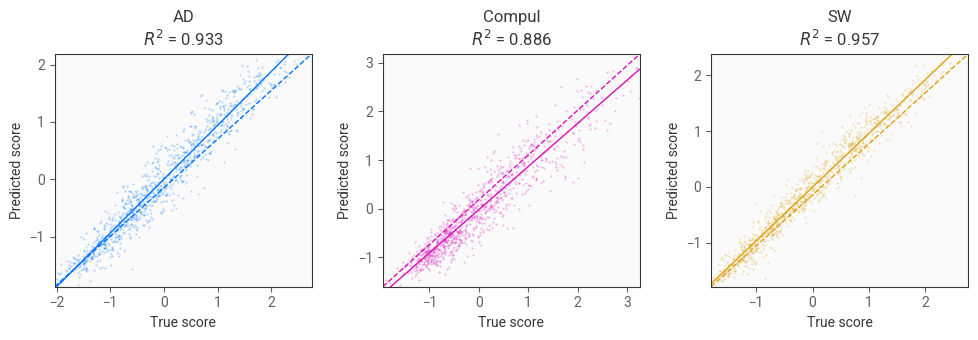

In [18]:
from facsimile.utils import simple_predict

# Get predictions
y_pred = simple_predict(best_clf.get_weights(), X_reduced)

# Plot predictions
plot_predictions(y_test, y_pred, ["AD", "Compul", "SW"], scale=1)